In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

In [38]:
M_i/32*0.5*(3e8)**2/e  

467015625.0

In [14]:
# Physical constant
e = 1.6e-19 #[C] electron charge 
M_i = 32*1.6605e-27 #[kg] ion mass
m = 9.11e-31 #[kg] electron mass
k = 1.38e-23 #[m2 kg /s2 K] Boltzmann constant

# Experimental constant
p = 10e-3*133.33 #[mTorr to Pa]
R = 30e-3 #[m] plasma half-width
L = 330e-3 #[m] chamber length
Tg = 300 #[K] gas temperature
R_0 = 25e-3 #[m] chosen normalization length
B_0 = 0.03 #[T] magnetic field
gamma = 20 # electron-ion temperature ratio Te/Ti
#Te = 4.5 #[eV] electron temperature
Ti = Te/gamma
n_g = p/k/Tg #[m-3] neutral gas density
n_e0 = n_g * 2.75e-4 #experimental condition
alpha_0 = 1
n_n0 = alpha_0/n_e0

### 단위체크!!!

1. R은 정해진다. (이 논문에서 보고자하는게 R이 정해진 상태에서 $\alpha,n_{e0}$가 어떻게 되어야 하는지임, 거꾸로 $\alpha,n_{e0}$가 주어지면 R도 찾을수있을거같음)
2. R이 정해졌고 Boundary Condition (${\Gamma_e(R) = 0, n_e(R) = 0}$)을 만족해야한다. solve_bvp 사용할것
3. BC만족하는 Te를 찾는다. (여러개려나?)
4. Te도 나왔으니 $\nu_L$은 특정 RL값이 주어지면 결정된다.

초기 주어진값: R <br>
미지수 : E,N,U,V,W,Phi

In [41]:
def function(x, sol, p):
    Te = p[0]
    E = sol[0]
    N = sol[1]
    U = sol[2]
    V = sol[3]
    W = sol[4]
    Phi = sol[5]
    
    I = E+N
    K_iz = 2.34e-15*Te**1.03*np.exp(-12.29/Te) #[m3/s]
    K_att = 1.07e-15*Te**-1.391*np.exp(-6.26/Te) #[m3/s]
    K_rec = 5.2e-14*(0.026/Ti)**0.44 #[m3/s]
    nu_i = 3.95e-16*n_g #[s-1]
    nu_e = 4.7e-14*Te**0.5*n_g #[s-1]
    nu_n = 3.95e-16*n_g #[s-1]

    w_ce = e*B_0/m
    Di = e*Ti/(M_i*nu_i)
    nu_L = 2*Di/(R*L)*(1+Te/Ti)**0.5

    G = n_g/n_e0
    Cs = np.sqrt(e*Te/M_i)
    A_i = n_e0*R_0*K_iz/Cs
    A_a = n_e0*R_0*K_att/Cs
    B_i = n_e0*R_0*K_rec/Cs
    C_i = R_0*nu_i/Cs
    C_e = R_0*nu_e/Cs
    C_n = R_0*nu_n/Cs
    Omega = R_0*w_ce/Cs 
    Epsilon_i = gamma #Te/Ti는 설정값으로줌
    Epsilon_n = gamma #Te/Tn, Ti=Tn
    Zeta = 1 #M_i/M_n, Mi=Mn
    D = R_0*nu_L/Cs
    Del = (A_i+A_a)*G+C_e
    Delta = Del*(m/M_i)*(1+Omega**2/Del**2)
    print(E)
    M = np.array([[V, 0, 0, E, 0, 0],
                  [U, U, I, 0, 0, 0],
                  [0, W, 0, 0, N, 0],
                  [1, 0, 0, 0, 0, E],
                  [1/Epsilon_i+U**2, 1/Epsilon_i+U**2, 2*I*U, 0, 0, -I],
                  [0, Zeta/Epsilon_n+W**2, 0, 0, 2*N*W, Zeta*N]], dtype='float64') 

    RHS = np.array([(A_i-A_a)*G*E-D*I,
                    A_i*G*E-B_i*I*N-D*I,
                    A_a*G*E-B_i*I*N,
                    -Delta*E*V,
                    -C_i*I*U,
                    -C_n*N*W], dtype='float64')
    
    res = np.linalg.solve(M,RHS)
    #res = np.linalg.solve(M,RHS)
    return res
    
def bc(y0, yR, p):
    Te = p[0]
    return np.array([y0[0]-1, y0[1]-alpha_0, y0[2], y0[3], y0[4], y0[5], yR[0]])

x = np.linspace(0,R,10) #(10,)
y = np.full((6,x.shape[0]), 0) #(6,10)
#y = np.random.rand(6,x.shape[0])
Te = 2
print(y.shape)
print(x.shape, y.shape)
res = solve_bvp(function, bc, x, y, (Te,), verbose=2, max_nodes=10000)
print(res.message)

x_measles_plot = np.linspace(0, 1, 100)
y_measles_plot = res.sol(x_measles_plot)
plt.plot(x_measles_plot, y_measles_plot[0])
plt.plot(x_measles_plot, y_measles_plot[1])


(6, 10)
(10,) (6, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


ValueError: setting an array element with a sequence.

In [28]:
E = 1
N = 2
U = 3
V = 4
W = 5
Epsilon_i =3
Epsilon_n =2
Zeta =1
 
M = np.array([[V, 0, 0, E, 0, 0],
              [U, U, (E+N), 0, 0, 0],
              [0, W, 0, 0, N, 0],
              [1, 0, 0, 0, 0, E],
              [1/Epsilon_i+U**2, 1/Epsilon_i+U**2, 2*(E+N)*U, 0, 0, -(E+N)],
              [0, Zeta/Epsilon_n+W**2, 0, 0, 2*N*W, Zeta*N]], dtype='float64')
print(np.shape(M))
RHS = np.array([1,
                3,
                4,
                5,
                7,
                1], dtype='float64')
                
result = np.vstack(np.linalg.solve(M,RHS))
print(np.shape(result),result)
print(M@result)

(6, 6)
(6, 1) [[-4.30178326]
 [ 2.35116598]
 [ 2.95061728]
 [18.20713306]
 [-3.87791495]
 [ 9.30178326]]
[[1.]
 [3.]
 [4.]
 [5.]
 [7.]
 [1.]]


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[4. 4. 4. 4. 4.]
 [0. 0. 0. 0. 0.]]


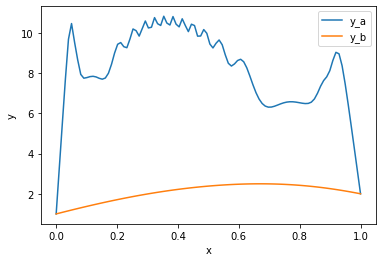

In [43]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
    
def fun(x, y):
    return np.vstack((y[1], -np.exp(y[0])))

def bc(ya, yb):
    return np.array([ya[0]-1, yb[0]-2])

x = np.linspace(0, 1, 5)
y_a = np.zeros((2, x.size))
y_b = np.zeros((2, x.size))
y_b[0] = 4
print(y_a)
print(y_b)
res_a = solve_bvp(fun, bc, x, y_a)
res_b = solve_bvp(fun, bc, x, y_b)

x_plot = np.linspace(0, 1, 100)
y_plot_a = res_a.sol(x_plot)[0]
y_plot_b = res_b.sol(x_plot)[0]


plt.plot(x_plot, y_plot_a, label='y_a')
plt.plot(x_plot, y_plot_b, label='y_b')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [85]:
###mini
def func(x, sol):
    E = sol[0]
    V = sol[1]
    
    M = np.array([[2, 1],[1, 2]])
    RHS = np.array([2, 3])
    return np.linalg.solve(M,RHS)
    
def bc(y0,y1):
    return [y0[0],y1[0]]

point = 10
x = np.linspace(0,1,point)    
y0 = np.full((2, x.shape[0]),0)

solve_bvp(func,bc,x,y0)

ValueError: `fun` return is expected to have shape (2, 10), but actually has (2,).

In [31]:
def fun_flow(x, y, p):
    A = p[0]
    return np.array(
        [y[1], y[2], 100 * (y[1]**2 - y[0]*y[2] - A),
        y[4], -100 * y[0] * y[4] - 1, y[6], -70 * y[0] * y[6]]
    )


def bc_flow(ya, yb, p):
    A = p[0]
    return np.array([ya[0], ya[1], yb[0] - 1, yb[1], ya[3], yb[3], ya[5], yb[5] - 1])

x_flow = np.linspace(0, 1, 10)
y_flow = np.ones((7, x_flow.shape[0]))

In [32]:
res_flow = solve_bvp(fun_flow, bc_flow, x_flow, y_flow, p=[1], verbose=2)
print("Found A={:.4f} --- matches with the value from the paper.".format(res_flow.p[0]))

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.30e+00       5.27e-16          10             18       
       2          2.42e-02       5.29e-23          28             12       
       3          3.47e-03       5.29e-23          40              2       
       4          7.51e-04       3.42e-22          42              0       
Solved in 4 iterations, number of nodes 42. 
Maximum relative residual: 7.51e-04 
Maximum boundary residual: 3.42e-22
Found A=2.7606 --- matches with the value from the paper.


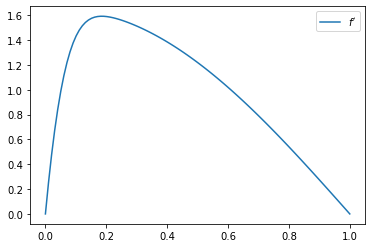

In [43]:
x_flow_plot = np.linspace(0, 1, 100)
y_flow_plot = res_flow.sol(x_flow_plot)
plt.plot(x_flow_plot, y_flow_plot[1], label="$f'$")
plt.legend()

In [27]:
a = np.vstack(([1],[2],[3]))
a.shape

(3, 1)

In [34]:
def fun_flow(x, y, p):
    A = p[0]
    print(y[1])
    return np.vstack((
        y[1], y[2], 100 * (y[1]**2 - y[0]*y[2] - A),
        y[4], -100 * y[0] * y[4] - 1, y[6], -70 * y[0] * y[6]
    ))


def bc_flow(ya, yb, p):
    A = p[0]
    return np.array([ya[0], ya[1], yb[0] - 1, yb[1], ya[3], yb[3], ya[5], yb[5] - 1])

x_flow = np.linspace(0, 1, 10)
y_flow = np.ones((7, x_flow.shape[0]))

res_flow = solve_bvp(fun_flow, bc_flow, x_flow, y_flow, p=[1], verbose=2)

print("Found A={:.4f} --- matches with the value from the paper.".format(res_flow.p[0]))



[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.00000003 1.00000003 1.00000003 1.00000003 1.00000003 1.00000003
 1.00000003 1.00000003 1.00000003 1.00000003]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.00000003 1.00000003 1.00000003 1.00000003 1.00000003 1.00000003
 1.00000003 1.00000003 1.00000003]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2.73114864e-14 9.14285748e-01 1.20284613e+00 1.25490782e+00
 1.20168231e+00 1.08406291e+00 9.10788870e-01 6.78538808e-01
 3.78780367e-01 8.88178420e-16]
[1.77036437 1.51699762 1.39078156 1